## 反激电源计算

In [772]:
# 头文件
import math as m
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import control as ctrl
# from scipy.interpolate import interp1d
# from sympy import symbols, Eq, solve, I
from pathlib import Path
from json_pre import load_core_parameters
import json

### 输入参数

In [773]:
V_IN = 220  # 常规输入电压 (V)
V_AC_MIN = 85  # 最小输入电压 (V)
V_AC_MAX = 265  # 最大输入电压 (V)

f_LINE_MIN = 47  # 最小输入频率 (Hz)
f_LINE_MAX = 63  # 最大输入频率 (Hz)

V_BIAS = 15  # 电压偏置 (V)  用于给IC供电

P_OUT = 120  # 输出功率 (W)
V_OUT = 24  # 输出电压 (V)
I_OUT = P_OUT / V_OUT  # 输出电流(A)
R_OUT = V_OUT / I_OUT  # 输出阻值(Ω)

V_RIPPLE = 100e-3  # 输出纹波电压(V)
V_DELTA = V_RIPPLE / V_OUT

ETA = 0.85  # 效率

F_SW = 100e3  # 开关频率 (Hz)

P_IN = P_OUT / ETA  # 输入功率 (W)

V_DS_Rated = 800  # MOSFET 额定电压 (V)

K_RP = 0.8  # 电流脉动系数
V_F = 0.7  # 输出二极管正向压降 (V)

K_O = 0.4  # 反激变压器窗口填充系数
B_W = 0.2  # 变压器的磁通量(T)
B_MAX = 0.15  # 变压器的最大磁通密度 (mT)   DCM下，一般取0.2-0.26T；CCM下，一般取0.12-0.18T

K_JP = 3  # 初级电流密度系数
K_JS = 5.5  # 次级电流密度系数

### 单相桥式整流滤波电路

In [774]:
V_BULK_MIN = V_AC_MIN / 1.15  # 最小整流电压
V_BULK_MAX = V_AC_MAX * m.sqrt(2)  # 最大整流电压
I_AC_MAX = P_IN / V_AC_MIN  # 最大输入电流

print("最小整流电压 V_BULK_MIN: %.2f" % V_BULK_MIN)
print("最大整流电压 V_BULK_MAX: %.2f" % V_BULK_MAX)
print("最大输入电流 I_AC_MAX: %.2f" % I_AC_MAX)

最小整流电压 V_BULK_MIN: 73.91
最大整流电压 V_BULK_MAX: 374.77
最大输入电流 I_AC_MAX: 1.66


### 1. 输入电容

In [775]:
C_IN = (
    2 * P_IN * (0.25 + 1 / np.pi * np.arcsin(V_BULK_MIN / m.sqrt(2) / V_AC_MIN))
) / ((2 * m.pow(V_AC_MIN, 2) - m.pow(V_BULK_MIN, 2)) * f_LINE_MIN)
print("输入电容 C_in = %.2fuF" % (C_IN * 1e6))

输入电容 C_in = 308.03uF


### 2. 变压器匝数比和最大占空比

In [776]:
V_REFLECTED_0 = 0.8 * (V_DS_Rated - 1.3 * V_BULK_MAX)  # 最大反射输出电压
print("最大反射电压 %.2fV" % V_REFLECTED_0)
V_REFLECTED = 220
if V_REFLECTED > V_REFLECTED_0:
    raise ValueError("反射电压太大，请重新设置！")
elif (V_REFLECTED_0 - V_REFLECTED) > 50:
    raise ValueError("反射电压太小，请重新设置！")
print("反射电压取 %.2fV\n" % V_REFLECTED)

N_PS = V_REFLECTED / V_OUT  # 匝数比
print("计算匝数比 %.2f" % N_PS)

最大反射电压 250.24V
反射电压取 220.00V

计算匝数比 9.17


### ... 变压器磁芯

In [777]:
V_REFLECTED = N_PS*V_OUT
print(f"反射电压 V_REFLECTED = {V_REFLECTED:.2f} V")

反射电压 V_REFLECTED = 220.00 V


In [778]:
V_DIODE = V_BULK_MAX / N_PS + V_OUT  # 输出二极管电压
print("输出二极管电压 %.2fV\n" % V_DIODE)

D_MAX = (N_PS * (V_OUT + V_F)) / (V_BULK_MIN + N_PS * (V_OUT + V_F))  # 最大占空比
print("CCM模式最大占空比 %.2f" % D_MAX)

输出二极管电压 64.88V

CCM模式最大占空比 0.75


In [779]:
PQ_json_path = Path("BYDZ_PQCore.json")
PQ_Core_data = load_core_parameters(PQ_json_path)

Core_Type = "PQ3530"
params = PQ_Core_data[Core_Type]
Ae = params["Ae"]  # 磁芯有效截面积 (mm^2)

print(f"磁芯有效截面积 Ae = {Ae:.2f} mm^2")
Aw = params["Aw"]  # 磁芯窗口面积 (mm^2)
print(f"磁芯窗口面积 Aw = {Aw:.4f} mm^2")
AP = Ae * 1e-2 * Aw * 1e-2  # 磁芯有效面积 (cm^4)
print(f"磁芯有效面积 AP = {AP:.4f} cm^4")

磁芯有效截面积 Ae = 180.70 mm^2
磁芯窗口面积 Aw = 176.0000 mm^2
磁芯有效面积 AP = 3.1803 cm^4


#### 变压器电感

In [780]:
L_P_0 = 1/2*m.pow(V_BULK_MIN*D_MAX, 2) /(P_IN*F_SW*0.5)
print("CCM 反激式的电感器计算容量为：%.2fmH" % (1e3 * L_P_0))
L_P = 0.6e-3
print("CCM 反激式的电感器实际取值为：%.2fmH\n" % (1e3 * L_P))

CCM 反激式的电感器计算容量为：0.22mH
CCM 反激式的电感器实际取值为：0.60mH



迭代计算实际匝数和占空比

In [ ]:
D_MAX = (N_PS * (V_OUT + V_F)) / (V_BULK_MIN + N_PS * (V_OUT + V_F))  # 最大占空比
D_MAX_TEMP = D_MAX
I_1 = P_IN / (D_MAX * V_BULK_MIN)
print("迭代开始时最大占空比 D_MAX = %.4f%%" % (D_MAX * 100))
while True:
    # N_P_0 = V_BULK_MIN * 1 / 100e3 * D_MAX * 100 / (B_MAX * Ae * 1e-4)
    N_P_0 = L_P * I_1 * 1e6 / (B_MAX * Ae)
    N_P = round(N_P_0)
    N_S_0 = N_P / N_PS
    N_S = round(N_S_0)
    N_PS = N_P / N_S

    V_DIODE = V_BULK_MAX / N_PS + V_OUT  # 输出二极管电压

    D_MAX_TEMP = (N_PS * (V_OUT + V_F)) / (
        V_BULK_MIN + N_PS * (V_OUT + V_F)
    )  # 最大占空比
    if abs(D_MAX - D_MAX_TEMP) > 0.001:
        D_MAX = D_MAX_TEMP
        continue
    else:
        print("迭代结束时最大占空比 D_MAX = %.4f%%" % (D_MAX * 100))
        break

print(f"变压器一次侧匝数N_P = {N_P}")
print(f"变压器二次侧匝数N_S = {N_S}")
print(f"变压器实际变比 N_PS = {N_PS:.2f}")

输入电流 I_1 = 2.5224 A
迭代开始时最大占空比 D_MAX = 75.7221%
迭代结束时最大占空比 D_MAX = 75.7221%
变压器一次侧匝数N_P = 56
变压器二次侧匝数N_S = 6
变压器实际变比 N_PS = 9.33


In [782]:
N_PA_0 = N_PS * V_OUT / V_BIAS  # 辅助电源匝数比
print("计算辅助电源匝数比 %.2f" % N_PA_0)
N_PA = 13
if (N_PS / N_PA) * V_OUT > 20:
    raise ValueError("辅助电源匝数比太大，请重新设置！")
elif (N_PS / N_PA) * V_OUT < 15:
    raise ValueError("辅助电源匝数比太小，请重新设置！")
print("辅助电源匝数比取 %.d" % N_PA)
print("辅助绕组电压%.2fV\n" % (N_PS / N_PA * V_OUT))

N_A_0 = N_P/N_PA
print("计算辅助绕组匝数 %.2f" % N_A_0)
N_A = round(N_A_0)
N_PA = N_P/N_A
print("辅助绕组匝数取 %.d" % N_A)
print("辅助绕组实际电压%.2fV" % (N_PS / N_PA * V_OUT))

计算辅助电源匝数比 14.93
辅助电源匝数比取 13
辅助绕组电压17.23V

计算辅助绕组匝数 4.31
辅助绕组匝数取 4
辅助绕组实际电压16.00V


#### 气隙

In [783]:
mu_r = 1 # 空气相对磁导率
mu_0 = 0.4*np.pi*1e-7 # 铁氧体相对磁导率
l_g = mu_0*mu_r*N_P*N_P*Ae*1e-6/L_P*1e3 # 气隙长度
print(f"气隙长度 l_g = {l_g:.2f} mm")

气隙长度 l_g = 0.12 mm


### 3. 初级电流

In [784]:
I_PK_MOSFET = (P_IN / (V_BULK_MIN * (N_PS * V_OUT / (V_BULK_MIN + N_PS * V_OUT)))) + (
    V_BULK_MIN / (2 * L_P) * (N_PS * V_OUT / (V_BULK_MIN + N_PS * V_OUT)) / F_SW
)
print("CCM 反激式的初级MOSFET峰值电流为：%.2fA\n" % I_PK_MOSFET)

I_RMS_MOSFET = np.sqrt(
    (m.pow(D_MAX, 3) / 3) * m.pow(V_BULK_MIN / (L_P * F_SW), 2)
    - ((m.pow(D_MAX, 2) * I_PK_MOSFET * V_BULK_MIN) / (L_P * F_SW))
    + (D_MAX * m.pow(I_PK_MOSFET, 2))
)
print("CCM 反激式的初级MOSFET 均方根电流为：%.2fA\n" % I_RMS_MOSFET)

I_PK_DIODE = N_PS * I_PK_MOSFET
print("CCM 反激式的次级二极管峰值电流为：%.2fA" % I_PK_DIODE)

CCM 反激式的初级MOSFET峰值电流为：3.00A

CCM 反激式的初级MOSFET 均方根电流为：2.22A

CCM 反激式的次级二极管峰值电流为：28.03A


### 4. 输出电容器

In [785]:
C_OUT_MIN = (I_OUT * (N_PS * V_OUT) / (V_BULK_MIN + N_PS * V_OUT)) / (
    V_DELTA * V_OUT * F_SW
)
print("最小输出电容%.2f uF" % (C_OUT_MIN * 1e6))

C_OUT = 500 * 1e-6
if C_OUT < C_OUT_MIN:
    raise Exception("输出电容过小")
elif C_OUT - C_OUT_MIN > 500e-6:
    raise Exception("输出电容过大")
print("输出电容%.2f uF" % (C_OUT * 1e6))

最小输出电容375.95 uF
输出电容500.00 uF


### 5. 电流检测网络

In [786]:
with open("RC_Data.json", "r") as f:
    data = json.load(f)
    RCS_list = data["RCS"]
# print("RCS列表：", RCS_list)

for R_CS_0 in RCS_list:
    if m.pow(I_PK_MOSFET, 2) * R_CS_0 < 2:
        R_CS = R_CS_0
        continue
    else:
        break
R_CS = 0.1
print("电流采样电阻R_CS：%.2f Ohm" % R_CS)

V_OFFSET = 1 - I_PK_MOSFET * R_CS
print("失调电压值V_OFFSET：%.2fV" % V_OFFSET)

R_CSF = 3e3
V_REF = 5
R_P = 1 / (V_OFFSET / V_REF / R_CSF) - R_CSF

print("滤波元件 RCSF：%.2f Ohm" % R_CSF)
print("分压电阻R_P：%.2f Ohm" % R_P)

电流采样电阻R_CS：0.10 Ohm
失调电压值V_OFFSET：0.70V
滤波元件 RCSF：3000.00 Ohm
分压电阻R_P：18439.02 Ohm


### 6. 栅极驱动电阻

RG 是电源开关 QSW 的栅极驱动电阻器。该电阻值的选择必须与 EMI 符合性测试和效率测试结合起来进行。对 RG 使用较大的电阻值会减慢 MOSFET 的导通和关断速度。开关速度越慢 EMI 会降低，但开关损耗也会增加。必须仔细权衡开关损耗和 EMI 性能。对于此设计，选择了 10Ω 电阻器用于栅极驱动电阻器。

### 7. VREF电容器

高精度 5V 基准电压具有几项重要的功能。基准电压在内部分压至 2.5V，并连接到误差放大器的同相输入端，以实现精确的输出电压调节。基准电压的其他作用包括为振荡器上限和下限等功能设置内部偏置电流和阈值。因此，必须使用陶瓷电容器 (CVREF) 对基准电压进行旁路，为此转换器选择了 1μF、16V 陶瓷电容器。该电容器在物理印刷电路板布局布线上的位置必须尽可能靠近各自的 VREF 和 GROUND 引脚。

### 8. RT/CT
内部振荡器使用计时电容器 (CCT) 和计时电阻器 (RRT) 来对振荡器频率和最大占空比进行编程。可根据节 8.2.3 中的曲线对工作频率进行编程，其中一旦选择了计时电容器，即可找到计时电阻器。计时电容器最好具有平坦的温度系数，这是大多数 COG 或 NPO 型电容器的典型特性。

In [787]:
with open("RC_Data.json", "r") as f:
    data = json.load(f)
    R0603_list = data["R0603"]
    C0603_list = data["C0603"]

# print("C0603:", C0603_list)
# print("R0603:", R0603_list)

F_OSC_TEMP = 200e3
for C0603 in C0603_list:
    for R0603 in R0603_list:
        F_OSC = 1.72 / (C0603 * R0603)
        if abs(F_OSC - F_SW) < abs(F_OSC_TEMP - F_SW):
            F_OSC_TEMP = F_OSC
            R_RT = R0603
            C_CT = C0603

F_OSC = 1.72 / (C_CT * R_RT)
print("计时电容器容量为：%.2f pF" % (C_CT * 1e12))
print("计时电阻器值为：%.2f kOhm" % (R_RT * 1e-3))
print("时钟频率为：%.2f kHz" % (F_OSC / 1e3))

计时电容器容量为：470.00 pF
计时电阻器值为：36.00 kOhm
时钟频率为：101.65 kHz


### 9. 启动电路

在启动时，IC 通过高压电阻器 RSTART 直接从高压体获得功率。启动电阻器的选择是功率损耗和启动时间之间进行权衡。在最小输入电压下流过 RSTART 的电流必须高于 UVLO 条件下的 VCC 电流（最大值为 1mA）。为RSTART 选择了 100kΩ 的电阻，在低压线路条件下提供 1mA 的启动电流。启动电阻器在物理上由两个 50kΩ 电阻器串联组成，以满足高压要求和高压线路的额定功率。
在 VCC 充电超过 UVLO 导通阈值后，UC2842 开始消耗全部工作电流。VCC 电容器需要提供足够的能量，以防止在启动期间电压下降到 UVLO 关断阈值以下，然后输出才能够达到调节电平。大容量电容可容纳更多能量，但会导致启动时间变慢。该设计中选择了 120μF 电容器，以提供足够的能量并保持启动时间大概 2 秒。

### 10. 电压反馈补偿

#### 10.1 功率级点和零点

In [788]:
L_P_Crit1 = R_OUT * m.pow(N_PS, 2) / (2 * F_SW) * m.pow(V_IN / (V_IN + V_OUT * N_PS), 2)
L_P_Crit2 = (
    R_OUT * m.pow(N_PS, 2) / (2 * F_SW) * m.pow(V_AC_MAX / (V_AC_MAX + V_OUT * N_PS), 2)
)
L_P_Crit3 = (
    R_OUT * m.pow(N_PS, 2) / (2 * F_SW) * m.pow(V_AC_MIN / (V_AC_MIN + V_OUT * N_PS), 2)
)
print("220V时电路220V时电路 %.2f "% (L_P_Crit1*1e3), "mH")
print("265V时电路 220V时电路%.2f "% (L_P_Crit2*1e3), "mH")
print("85V时电路的临界电感 %.2f "% (L_P_Crit3*1e3), "mH")

if L_P > L_P_Crit3:
    print("85V时电路工作在CCM模式")
if L_P > L_P_Crit1:
    print("220V时电路工作在CCM模式")
if L_P > L_P_Crit2:
    print("265V时电路工作在CCM模式")

if (L_P > L_P_Crit3) & (L_P > L_P_Crit1) & (L_P > L_P_Crit2):
    print("电路在整个输入电压范围内工作在CCM模式")

220V时电路220V时电路 0.51  mH
265V时电路 220V时电路0.61  mH
85V时电路的临界电感 0.16  mH
85V时电路工作在CCM模式
220V时电路工作在CCM模式


In [789]:
R_CS_0 = 1 / I_PK_MOSFET
A_CS = 3  # 内部电流检测增益
D = N_PS * V_OUT / (V_BULK_MIN + (N_PS * V_OUT))
Tau_L = 2 * L_P * F_SW / (R_OUT * m.pow(N_PS, 2))
M = V_OUT * N_PS / V_BULK_MIN
G_0 = (
    R_OUT * N_PS / (R_CS_0 * A_CS) * 1 / (m.pow(1 - D, 2) / Tau_L + (2 * M) + 1)
)  # 直流开环增益
print("直流开环增益为：%.4f" % G_0, "dB")
print("")

R_ESR = 0.8 / 4
Omega_ESR_Z = 1 / (R_ESR * C_OUT)
F_ESR_Z = Omega_ESR_Z / (2 * m.pi)
print("ESR频率为：%.2f" % F_ESR_Z, "Hz")
print("")

Omega_RHP_Z = R_OUT * m.pow(1 - D, 2) * m.pow(N_PS, 2) / (L_P * D)
F_RHP_Z = Omega_RHP_Z / (2 * m.pi)
print("RHP频率为：%.2f" % F_RHP_Z, "Hz")

直流开环增益为：6.1645 dB

ESR频率为：1591.55 Hz

RHP频率为：9080.05 Hz


功率级有一个主导极点 ωP1，它位于感兴趣的区域中，处在较低的频率 fP1 处，与占空比 D、输出负载和输出电容有关。还有一个双极点放在转换器开关频率的一半处。

In [790]:
Omega_P1 = (m.pow(1 - D, 3) / Tau_L + 1 + D) / (R_OUT * C_OUT)
F_P1 = Omega_P1 / (2 * m.pi)
Omega_P2 = m.pi * F_SW
F_P2 = F_SW / 2
print("F_P1: %.2f Hz" % F_P1)
print("F_P2: %.2f Hz" % F_P2)

F_P1: 119.71 Hz
F_P2: 50000.00 Hz


#### 10.2 斜率补偿

由理想的质量系数Q_P来计算M_ideal，再由电感器上升斜率S_n来计算补偿斜率 S_e

In [791]:
M_ideal = (1 / m.pi + 0.5) / (1 - D)
M_C = M_ideal
print("斜坡补偿系数的理想值 M_ideal = %.4f" % M_ideal)
S_n = V_BULK_MIN * R_CS_0 / L_P  # V/s  Ω
print("电感器上升斜率 S_n = %.3f mV/us" % (S_n * 1e-3))
S_e = (M_C - 1) * S_n  # V/s
print("补偿斜率 S_e = %.3f mV/us" % (S_e * 1e-3))
Q_P_0 = 1 / (m.pi * (M_C * (1 - D) - 0.5))
print("理想质量系数 Q_P_0 = %.3f" % Q_P_0)

斜坡补偿系数的理想值 M_ideal = 3.2983
电感器上升斜率 S_n = 41.016 mV/us
补偿斜率 S_e = 94.266 mV/us
理想质量系数 Q_P_0 = 1.000


In [792]:
t_ON_min = D / F_SW
V_OSC_Cpp = 1.7
S_OSC = V_OSC_Cpp / t_ON_min
print("%.2f mV/us" % (S_OSC * 1e-6 * 1e3))

226.09 mV/us


In [793]:
with open("RC_Data.json") as f:
    data = json.load(f)
    R0603_list = data["R0603"]

Q_P = 1.2
for R0603_RAMP in R0603_list:
    if R0603_RAMP < 10e3:
        continue
    for R0603_CSF in R0603_list:
        S_e_Temp = S_OSC / (R0603_RAMP / R0603_CSF + 1)
        M_C_Temp = S_e_Temp / S_n + 1
        Q_P_Temp = 1 / (m.pi * (M_C_Temp * (1 - D) - 0.5))
        if abs(Q_P - Q_P_0) > abs(Q_P_Temp - Q_P_0):
            Q_P = Q_P_Temp
            R_RAMP = R0603_RAMP
            R_CSF = R0603_CSF

print("R_RAMP = %.2f" % (R_RAMP * 1e-3), "kOhm")
print("R_CSF = %.2f" % (R_CSF * 1e-3), "kOhm")
print("Q_P = %.4f" % Q_P)

R_RAMP = 18.00 kOhm
R_CSF = 13.00 kOhm
Q_P = 0.9897


#### 10.3 开环增益

In [794]:
s = ctrl.TransferFunction.s

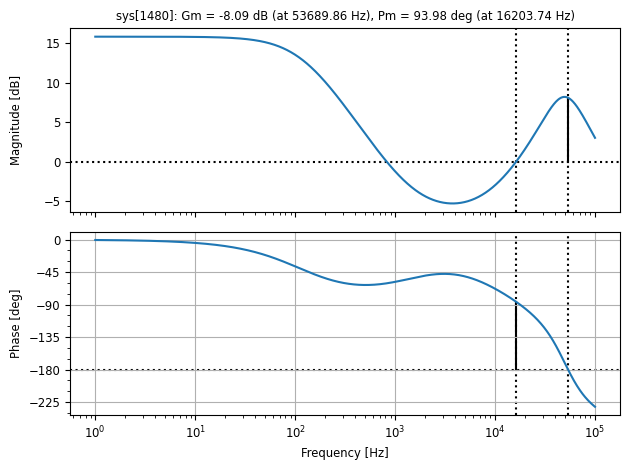

In [795]:
H_OPEN = (
    G_0
    * ((1 + s / Omega_ESR_Z) * (1 - s / Omega_RHP_Z) / (1 + s / Omega_P1))
    * (1 / (1 + s / (Omega_P2 * Q_P) + s * s / m.pow(Omega_P2, 2)))
)

freq_Hz = np.logspace(0, 5, 1000)
omega = 2 * np.pi * freq_Hz

plt.figure()
ctrl.bode_plot(H_OPEN, omega=omega, dB=True, Hz=True, display_margins=True)
plt.grid(True)
plt.show()

#### 10.4 补偿环路

In [796]:
F_BW = F_RHP_Z / 4
print("CCM 反激式的带宽: %.2f Hz" % F_BW)

CCM 反激式的带宽: 2270.01 Hz


##### 10.4.1 光耦TL431

In [797]:
REF_TL431 = 2.495  #  TL431参考值
I_FB_REF = 1e-3  #  分压器电流
R_FBU = (V_OUT - REF_TL431) / I_FB_REF
R_FBB = REF_TL431 / (V_OUT - REF_TL431) * R_FBU
print("分压器R_FBU:", R_FBU)
print("分压器R_FBB:", R_FBB)

with open("RC_Data.json", "r") as f:
    data = json.load(f)
    R0603_list = data["R0603"]

for R0603_FBU in R0603_list:
    if ((V_OUT - REF_TL431) / 1e-3 > R0603_FBU) | (
        (V_OUT - REF_TL431) / 0.5e-3 < R0603_FBU
    ):
        continue
    else:
        R_FBU = R0603_FBU
        break

R_FBB = REF_TL431 / (V_OUT - REF_TL431) * R_FBU

print("分压器R_FBU实际值:", R_FBU)
print("分压器R_FBB实际值: %.2f"% R_FBB)

分压器R_FBU: 21505.0
分压器R_FBB: 2495.0
分压器R_FBU实际值: 22000.0
分压器R_FBB实际值: 2552.43


为了获得良好的相位裕度，需要一个补偿器零点 fCOMPz，并且必须将其放置在所需带宽的 1/10 处

In [798]:
C_COMP_Z = 0.01e-6
F_COMP_Z = F_BW / 10
Omega_COMP_Z = 2 * np.pi * F_COMP_Z
R_COMP_Z = 1 / (Omega_COMP_Z * C_COMP_Z)
print("F_COMP_Z = %.2f Hz" % F_COMP_Z)
print("R_COMP_Z = %.2f kOhm" % (R_COMP_Z / 1e3))

F_COMP_Z = 227.00 Hz
R_COMP_Z = 70.11 kOhm


In [799]:
G_TL431 = (R_COMP_Z+1/(s*C_COMP_Z))*1/R_FBU

In [800]:
R_COMP_P = 10e3
C_COMP_P = 1/(Omega_ESR_Z*R_COMP_P)
print("R_COMP_P = %.4f Ohm" % R_COMP_P)
print("C_COMP_P = %.4f nF" % (C_COMP_P*1e9))

R_COMP_P = 10000.0000 Ohm
C_COMP_P = 10.0000 nF


In [801]:
R_FBG = 5.1e3
G_EA = (R_COMP_P / R_FBG) * (1 / (1 + s * C_COMP_P * R_COMP_P))
CTR = 1
R_OPTO = 1e3
R_LED = 1.3e3
# G_OPTO = CTR * R_OPTO / R_LED

# omega = np.logspace(0, 6, 1000)

response_H_OPEN = H_OPEN.frequency_response(F_BW*2*np.pi)
response_G_EA = G_EA.frequency_response(F_BW*2*np.pi)
response_G_TL431 = G_TL431.frequency_response(F_BW*2*np.pi)

mag_H_OPEN = response_H_OPEN.magnitude
mag_G_EA = response_G_EA.magnitude
mag_G_TL431 = response_G_TL431.magnitude

R_LED_0 = mag_H_OPEN*mag_G_EA*mag_G_TL431*CTR*R_OPTO
print(R_LED_0)
R_LED = 6.2e3
print("R_LED = %.2f Ohm" % R_LED)


[[[2103.50056522]]]
R_LED = 6200.00 Ohm


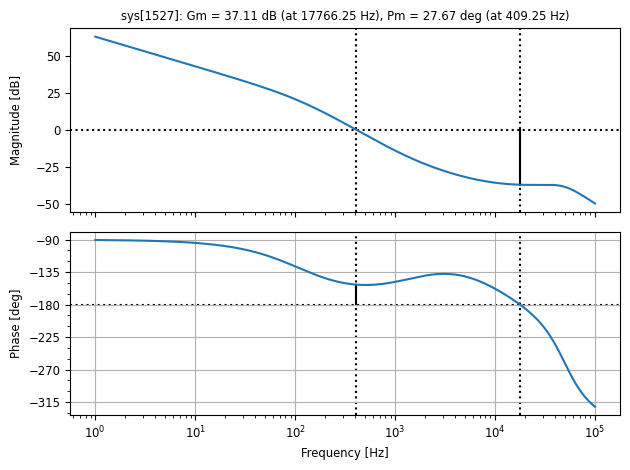

In [802]:
G_OPTO = CTR * R_OPTO / R_LED

G_CLOSED = (
    H_OPEN
    * (CTR * R_OPTO / R_LED)
    * (R_COMP_P / R_FBG)
    * (1 / (1 + s * C_COMP_P * R_COMP_P))
) * ((R_COMP_P + (1 / (s * C_COMP_Z))) / R_FBU)

freq_Hz = np.logspace(0, 5, 1000)
omega = 2 * np.pi * freq_Hz

plt.figure()
ctrl.bode_plot(G_CLOSED, omega=omega, dB=True, Hz=True, display_margins=True)
plt.grid(True)
plt.show()

### 变压器绕组计算

In [805]:
with open("BYDZ_Lizt.json", "r") as f:
    Lizt_data = json.load(f)

D_m = 2 * 66.1e-3 / m.sqrt(F_SW)
print("趋肤深度 D_m = %.4f mm" % (D_m * 1e3))

# print(type(Lizt_data["0.1*10"]["d"]))
I_RMS_DIODE = I_RMS_MOSFET * N_PS

# J_p = I_PRMS / ((m.pi * pow(D_p, 2) / 4) * m.pi * P_p)

Lizt_P_list = []
Lizt_S_list = []

for Lizt_Type in Lizt_data:
    K_JP_Temp = I_RMS_MOSFET/((m.pi * pow(Lizt_data[Lizt_Type]["d"], 2) / 4) * m.pi * Lizt_data[Lizt_Type]["N"])
    if(K_JP_Temp<K_JP):
        Lizt_P_list.append(Lizt_Type)

for Lizt_Type in Lizt_data:
    K_JS_Temp = I_RMS_DIODE/((m.pi * pow(Lizt_data[Lizt_Type]["d"], 2) / 4) * m.pi * Lizt_data[Lizt_Type]["N"])
    if(K_JS_Temp<K_JS):
        Lizt_S_list.append(Lizt_Type)

print("初级绕组利兹线类型：", Lizt_P_list)
# print("初级绕组利兹线外径：", Lizt_data[Lizt_P]["D"], "mm")
print("次级绕组利兹线类型：", Lizt_S_list)
# print("次级绕组利兹线外径：", Lizt_data[Lizt_S]["D"], "mm")

趋肤深度 D_m = 0.4181 mm
初级绕组利兹线类型： ['0.1*30', '0.1*35', '0.1*40', '0.1*50', '0.1*60', '0.1*70', '0.1*80', '0.1*90', '0.1*100', '0.1*120', '0.1*150', '0.1*160', '0.1*180', '0.1*200', '0.1*250', '0.1*300', '0.1*350', '0.1*400', '0.1*500', '0.25*7', '0.30*7']
次级绕组利兹线类型： ['0.1*160', '0.1*180', '0.1*200', '0.1*250', '0.1*300', '0.1*350', '0.1*400', '0.1*500']


### 12. RCD电路

In [804]:
V_MOS_MAX = V_DS_Rated*0.7 # 最大MOSfet电压
V_clamp  = V_MOS_MAX - V_BULK_MIN
L_K = 2.53*1e-6
print(f"V_clamp = {V_clamp:.2f} V")
C_clamp = L_K*m.pow(I_PK_MOSFET, 2)/(m.pow(V_clamp, 2)-m.pow(V_REFLECTED, 2))
print(f"C_clamp = {C_clamp*1e12:.2f} pF")
R_clamp = m.pow(V_clamp,2)/(0.5*L_K*m.pow(I_PK_MOSFET,2)*F_SW*(V_clamp-V_REFLECTED))
print(f"R_clamp = {R_clamp:.2f} Ohm")

V_clamp = 486.09 V
C_clamp = 121.47 pF
R_clamp = 778.19 Ohm
